# Isodensity lines in R and $\rho$

In [1]:
%matplotlib notebook

from IPython.core.display import display, HTML
from ipfnpytools.getsig import getsig
import ipfnpytools.aug_read as aug_read
from ipfnpytools.closest import closest
import matplotlib.pyplot as plt
from __future__ import print_function
from ipfnpytools.plot import plots
from warnings import warn
import numpy as np
from ipfnpytools.save_figure import save_figure
from ipfnpytools import rps_dump
from ipfnpytools.ddremoveELMData import ddremoveELMData
import reflectometry as rfl
from scipy.signal import medfilt

## Parameters

Change at your own risk. Not guaranteed it will not explode

In [50]:
# Shot number
shot = 35835

# Choose profile source between 'afs' and 'dump'
source = 'afs'

# If chosen 'dump', state the relative path
path = '/afs/ipp-garching.mpg.de/home/d/danielhfc/lab_rot/phd_part13_Georg_zscan/RPS_dump.34879'

# Magnetic equillibrium
equillibrium = "EQH"

# Adjust Isodensity parameters
n_iso = 10           # Number of lines
start_density = 3e18 # First isodensity
stop_density = 3e19  # Last isodensity

# Time to reject before each ELM peak [ms]
preft = 1

# Time to reject after each ELM peak [ms]
suft = 6

# Select diagnostic for testing ELM rejection ("Shotfile", "Signal")
diag = ("MAC", "Ipolsoli")

# Median filter number of points (n=1 is equivalente to the unfiltered signal)
median_points = 1

In [51]:
# Fetching data ---------------------------------------------------

time, lfs_signal, hfs_signal, lfs_area, hfs_area = rfl.fetch(shot, path if source=='dump' else None, verbose=True)

('time:', (45189,))
('lfs_signal:', (45189, 151))
('lfs_area:', (45189, 151))
('hfs_signal:', (45189, 151))
('hfs_area:', (45189, 151))


## Remove ELMs

Using the _ELM_ shotfile we mask the ELMs. To better filter out the ELMs we need to specify a rejection window arround the ELM peak. For example, we can reject one millisecond before the peak `preft = 1` and two milliseconds after the peak `suft=2`. To verify that the ELM rejection routine is working properly, we can test it on an arbitrary diagnostic, e.g., `MAC/Ipolsoli` or `POT/EMLa-Han`

**Change the parameters in the next cell accordingly.**

In [52]:
# Get ELM mask from the ELM shotfile
test_signal = getsig(shot, diag[0], diag[1])
elmmsk = ddremoveELMData(shot, test_signal.time, preft=preft*1e-3, suft=suft*1e-3)

<IPython.core.display.Javascript object>


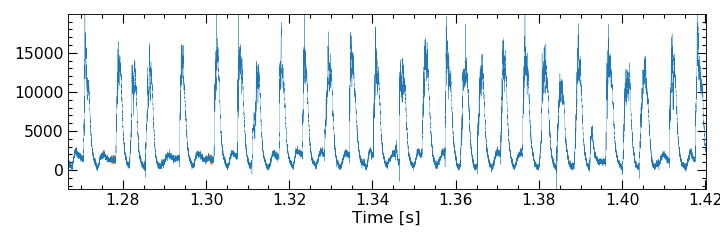

In [53]:
plt.figure(figsize=(9, 3))
plt.plot(test_signal.time, test_signal.data, lw=0.3)
plt.scatter(test_signal.time[elmmsk], test_signal.data[elmmsk], color='C1', marker='o', s=1)
plt.grid()
plt.xlabel("Time [s]")
plt.tight_layout()
# plt.xlim(2.2, 6.3)
# plt.ylim(-4e4, 4e4)

## Remove ELMs from the density profiles

In [54]:
mask = ddremoveELMData(shot, time, preft=preft*1e-3, suft=suft*1e-3)

In [55]:
# Apply the ELM removal mask
lfs_area_masked = lfs_area[mask]
hfs_area_masked = hfs_area[mask]

# Apply median filter
lfs_area_median = medfilt(lfs_area_masked, (median_points, 1))
hfs_area_median = medfilt(hfs_area_masked, (median_points, 1))

In [56]:
# Preprocessing --------------------------------------------------

#Isodensities. Transpose `area` so density is the first index
lfs_isodensity = lfs_area_masked.T
hfs_isodensity = hfs_area_masked.T
density = lfs_signal[0,:]

print("lfs_isodensity", lfs_isodensity.shape)
print("density", density.shape)
print("time", time.shape)

last_index = closest(density, stop_density)
first_index = closest(density, start_density)

if (last_index - first_index + 1) < n_iso:
    warn("Impossible drawing " + str(n_iso) + " isodensities, drawing only " + str(last_index - first_index + 1))

# ------------------------ CHOOSE ONE -------------------------------    
    
# Guarantees uniform spacing but not inclusion of last isodensity
# drawing_indexes = range(first_index, last_index + 1, (last_index - first_index + 1)/n_iso)

# Guarantees inclusion of last isodensity but not uniform spacing
drawing_indexes = np.rint(np.linspace(first_index, last_index, n_iso)).astype(np.int)

print("Drawing_indexes:", drawing_indexes)

lfs_isodensity (151, 36514)
density (151,)
time (45189,)
Drawing_indexes: [31 38 46 53 61 68 76 83 91 98]


## Check that ELM filtering and median filtering are working well

<IPython.core.display.Javascript object>


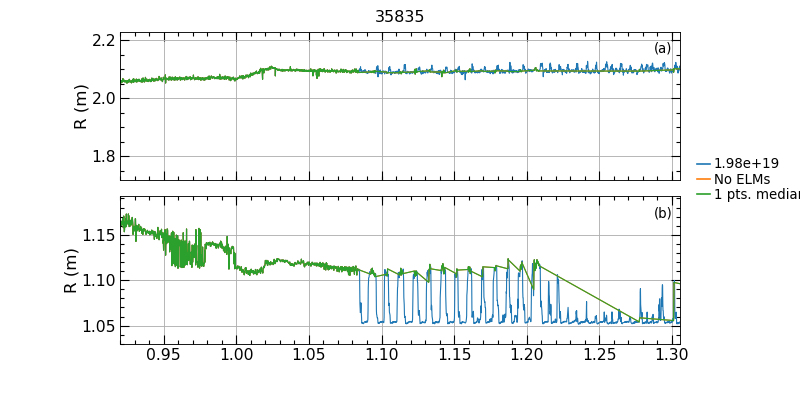

In [57]:
i = 80
fig0, axes0 = plots(x=[time, time[mask], time[mask], time, time[mask], time[mask]], 
                    y=[lfs_area.T[i], lfs_area_masked.T[i], lfs_area_median.T[i], hfs_area.T[i], hfs_area_masked.T[i], hfs_area_median.T[i]],
                    boxes=[0, 0, 0, 1, 1, 1],
                    labels=["%.2e" % density[i], "No ELMs", "%d pts. median" % median_points] + [None]*3,
                    linewidths=[1, 1, 1, 1, 1, 1],
                    legend_kw={'loc':'center left', 'bbox_to_anchor':[1.02,-1,0.3,2]},
                    sharex=True,
                    y_labels="R (m)",
                    title=str(shot))
fig0.set_size_inches(10, 5)
# axes[0].text(x=2.6, y=2, s="LFS", fontsize='x-large')
# axes[1].text(x=2.6, y=1.3, s="HFS", fontsize='x-large')
# plt.show()

<IPython.core.display.Javascript object>


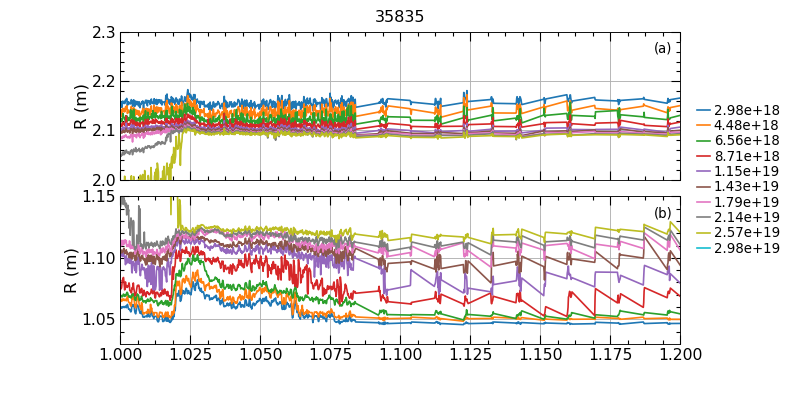

In [58]:
fig, axes = plots(x=time[mask], y=[lfs_area_median.T[i] for i in drawing_indexes] + [hfs_area_median.T[i] for i in drawing_indexes], 
                  boxes=[0]*n_iso + [1]*n_iso, 
                  labels=["%.2e" % density[i] for i in drawing_indexes] + [None]*len(drawing_indexes),
                  legend_kw={'loc':'center left', 'bbox_to_anchor':[1.02,-1,0.3,2]},
                  y_mins=[None]*n_iso + [None]*n_iso,
                  y_maxs=[None]*n_iso + [None]*n_iso,
                  sharex=True,
                  y_labels="R (m)",
                  title=str(shot))
fig.set_size_inches(10, 5)
# axes[0].text(x=2.6, y=2, s="LFS", fontsize='x-large')
# axes[1].text(x=2.6, y=1.3, s="HFS", fontsize='x-large')
# plt.show()

**Change the window manually, or by running the cell bellow**

In [64]:
axes[0].set_ylim(2.0, 2.3) # LFS R[m]
axes[1].set_ylim(1.03, 1.15) # HFS R[m]
axes[1].set_xlim(1, 1.2)     # Time[s]

(1, 1.2)

In [65]:
fig_name = "/afs/ipp-garching.mpg.de/home/d/danielhfc/phd-logbooks/logbooks/%d/%d_isodensity_no_ELM_R" % (shot, shot)
save_figure(fig, fig_name)

Figure saved to /afs/ipp-garching.mpg.de/home/d/danielhfc/phd-logbooks/logbooks/35835/35835_isodensity_no_ELM_R.png


## Adding separatrix information

In [ ]:
import dd #To read 
import kk_abock
import numpy as np
from ipfnpytools.trz_to_rhop import trz_to_rhop
from ipfnpytools.trhoptheta_to_rz import trhoptheta_to_rz
from ipfnpytools.getsig import getsig
import matplotlib.patheffects as pe

In [ ]:
# Set the antenna Z
zl = 0.14
zh = 0.07

parameters = 'IDG' if equillibrium == 'IDE' else 'GQH'

# Get lower x point
rxpu = getsig(shot, parameters, 'Rxpu')
zxpu = getsig(shot, parameters, 'Zxpu')

# Get upper x point
rxpo = getsig(shot, parameters, 'Rxpo')
zxpo = getsig(shot, parameters, 'Zxpo')

rho_x_u = trz_to_rhop(rxpu.time, rxpu.data, zxpu.data, 
                      shot=shot, eq=equillibrium)
rho_x_u = np.diag(rho_x_u)

rho_x_o = trz_to_rhop(rxpo.time, rxpo.data, zxpo.data, 
                      shot=shot, eq=equillibrium)
rho_x_o = np.diag(rho_x_o)

print(rho_x_u)
print(rho_x_o)


# # Walls
# inner_wall = 1.045
# outer_wall = 2.22

# inner_wall_rho = trz_to_rhop(3, inner_wall, zh, shot, eq=equillibrium)
# outer_wall_rho = trz_to_rhop(3, outer_wall, zl, shot, eq=equillibrium)
# rhol = trz_to_rhop(time, lfs_area, np.ones_like(lfs_area)*zl, shot, eq=equillibrium)
# rhoh = trz_to_rhop(time, hfs_area, np.ones_like(hfs_area)*zh, shot, eq=equillibrium)

In [ ]:
# Discover R of secondary separatrix

r_second_hfs = []
for t, rho in zip(rxpo.time, rho_x_o):
    r_second_hfs.append(trhoptheta_to_rz(t, rho, np.pi, shot=shot, eq=equillibrium, verbose=False)[0])
r_second_hfs = np.array(r_second_hfs)
    
r_second_lfs = []
for t, rho in zip(rxpo.time, rho_x_o):
    r_second_lfs.append(trhoptheta_to_rz(t, rho, 0, shot=shot, eq=equillibrium, verbose=False)[0])  
r_second_lfs = np.array(r_second_lfs)

# Separatrix positions
rin = getsig(shot, parameters, 'Rin')
raus = getsig(shot, parameters, 'Raus')

**The next cell draws the separatrix and secondary separatrix on the previous plot**

To refresh the plot and erase the separatrix information simply re-execute the plotting cell 

In [ ]:
axes[0].plot(raus.time, medfilt(raus.data, median_points), color='black', linestyle='--', label='sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])
axes[1].plot(rin.time, medfilt(rin.data, median_points), color='black', linestyle='--', label='sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])

axes[0].plot(rxpo.time, medfilt(r_second_lfs, median_points), color='red', linestyle='--', label='2$^{nd}$ sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])
axes[1].plot(rxpo.time, medfilt(r_second_hfs, median_points), color='red', linestyle='--', label='2$^{nd}$ sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])

axes[0].legend(loc='center left', bbox_to_anchor=[1.02,-1,0.3,2]);